## Stereo Vision (15pts)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

## Nikhil Bhaip (nb5hd)

In this lab we will apply our knowledge in the lectures on recovering depth from two 2D images.

### 1. Dense Stereo
In this section, you will be given two images taken from two different cameras whose viewing angles are parallel to each other and they are aligned with each other. Note: I'm resizing the images to 30% of their original size to speed up computations but probably better results can be obtained by running at full resolution.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


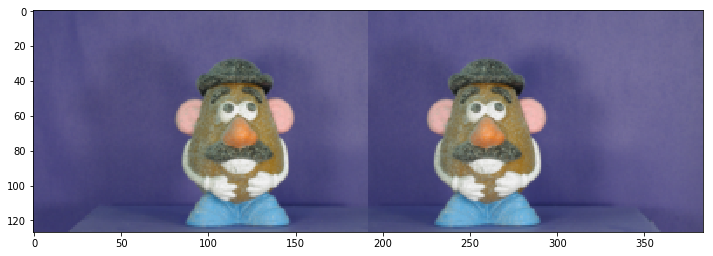

(127, 192, 3)
(127, 192, 3)


In [14]:
import scipy as sp
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from urllib.request import urlopen
import warnings
warnings.filterwarnings('ignore', '.*second argument.*',)

# Try maybe downloading the images in case the CS webserver goes down.
root = 'http://www.cs.virginia.edu/~vicente/vision/'

# Load image captured with the left camera.
img_left = root + 'potato-head-left.png'
img1 = ndimage.imread(urlopen(img_left), mode = 'RGB')
img1 = sp.misc.imresize(img1, 30, interp = 'bilinear');
img1 = img1.astype('float') / 255

# Load image captured with the right camera.
img_right = root + 'potato-head-right.png'
img2 = ndimage.imread(urlopen(img_right), mode = 'RGB')
img2 = sp.misc.imresize(img2, 30, interp = 'bilinear');
img2 = img2.astype('float') / 255

# Display the images.
plt.figure(figsize = (12, 12))
plt.imshow(np.concatenate((img1, img2), axis = 1))
plt.grid('off')
plt.show()

print(img1.shape)
print(img2.shape)


### 2. Dense Stereo - Disparity Map (SSD) (4pts)
Compute the disparity map of the two images using both SSD (sum of squared distances) over pixel windows of size 5x5 and display the resulting disparity map. Refer to the formula below:

$$\text{SSD}(p_1, p_2) = \sum (p_1 - p_2)^2$$

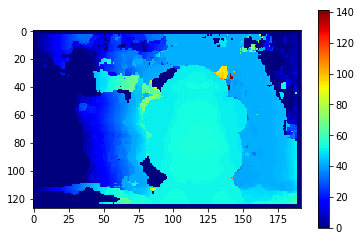

In [3]:
window_size = 5

# adjust window-size so that it is each side of the window is approximately 5
window_size = (window_size // 2) + 1
disparity_map1 = np.zeros((127,192))

for row in range(window_size, img1.shape[0]-window_size):
    for col in range(window_size, img1.shape[1]-window_size):
        window_1 = img1[row-window_size:row+window_size,col-window_size:col+window_size]
        disparity_row = np.zeros(186)
        i=0
        for col2 in range(window_size, img1.shape[1]-window_size):
            window_2 = img2[row-window_size:row+window_size,col2-window_size:col2+window_size]
            disparity_row[i] = np.sum((window_1-window_2)**2)
            i+=1
            
        # index with lowest cost
        min_index = np.argmin(disparity_row)
        disparity_map1[row,col] = col - min_index
# print(disparity_map1)
# Negative values have to be mistakes, so let's supress them.
plt.figure()
plt.imshow(disparity_map1 * (disparity_map1 > 0), cmap = 'jet')
plt.colorbar()
plt.grid('off')
plt.show()

### 3. Dense Stereo - Disparity Map (NCC) (4pts)
Compute the disparity map of the two images using NCC (normalized cross correlation) over pixel windows of size 5x5 and display the resulting disparity map. Refer to the formula below:

$$\text{NCC}(p_1, p_2) = \frac{\hat{p}_1 \cdot \hat{p}_2}{\lVert \hat{p}_1 \rVert \; \lVert \hat{p}_2 \rVert}; \quad \text{ s.t. } \quad \hat{p} = p - \text{mean}(p)$$

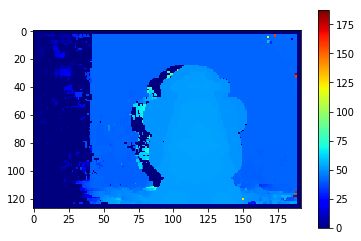

In [4]:
window_size = 5

# adjust window-size so that it is each side of the window is approximately 5
window_size = (window_size // 2) + 1
disparity_map2 = np.zeros((127,192))

for row in range(window_size, img1.shape[0]-window_size):
    for col in range(window_size, img1.shape[1]-window_size):
        window_1 = img1[row-window_size:row+window_size,col-window_size:col+window_size]
        
        norm_win_1 = window_1 - np.mean(window_1)
        mag_1 = np.sqrt(np.sum(norm_win_1*norm_win_1))
        
        disparity_row = np.zeros(186)
        i=0
        for col2 in range(window_size, img1.shape[1]-window_size):
            window_2 = img2[row-window_size:row+window_size,col2-window_size:col2+window_size]
            norm_win_2 = window_2 - np.mean(window_2)
            mag_2 = np.sqrt(np.sum(norm_win_2*norm_win_2))
            
            disparity_row[i] = np.sum(norm_win_1*norm_win_2) / (mag_1*mag_2)
            i+=1
            
        # index with lowest cost
        min_index = np.argmax(disparity_row)
        disparity_map2[row,col] = col - min_index
# Negative values have to be mistakes, so let's supress them.
plt.figure()
plt.imshow(disparity_map2 * (disparity_map2 > 0), cmap = 'jet')
plt.colorbar()
plt.grid('off')
plt.show()

### 4. Dense Stereo - Recovering Depth (4pts)
In this section you will convert the disparity map (either one) into a depth map assumming that the baseline distance between the two camera centers is 76mm, and the focal length is 19.35mm. Also, filter out dephts outside the Mr. Potatohead (e.g. background and mistakes). Feel free to filter out mistakes in whatever way you find useful. A sample output is included below. Please check this page to see how to plot in 3D https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

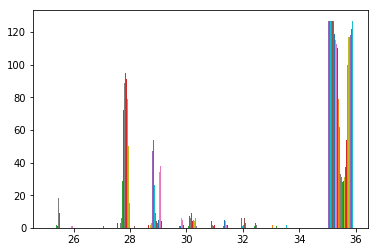

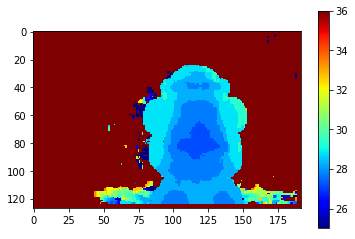

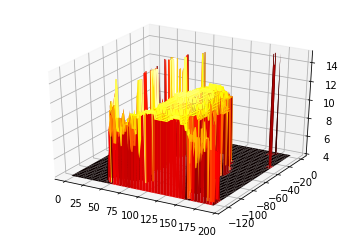

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

depth_map = np.zeros((127,192))
T = 76
F = 19.35
disparity_map_copy = np.copy(disparity_map2)


disparity_map_copy[disparity_map_copy<=5] = 5
# disparity_map_copy[disparity_map_copy<=5] = 1

for row in range(depth_map.shape[0]):
    for col in range(depth_map.shape[1]):
        depth_map[row,col] = T * F / disparity_map_copy[row,col]

# Filtering
thresh = np.percentile(depth_map,0.98)
depth_map[depth_map < 25]=25
depth_map[depth_map > 34]= 36

plt.hist(depth_map)
        
plt.figure()
plt.imshow(depth_map, cmap = 'jet')
plt.colorbar()
plt.grid('off')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
Y = np.arange(0, depth_map.shape[0])
X = np.arange(0, depth_map.shape[1])
X, Y = np.meshgrid(X, Y)
Z = 40-depth_map

surf = ax.plot_surface(X,-Y, Z, cmap=cm.hot)
plt.show()




### 5. Dense Stereo - Texture Mapping (3pts)
Repeate the same 3D plot but map the pixels in the input image to the 3D mesh using the colors option of the plot_surface function. I'm providing here the code, so no coding needed, you just need to run the code and make sure it outputs something similar (or better) to what is shown below.

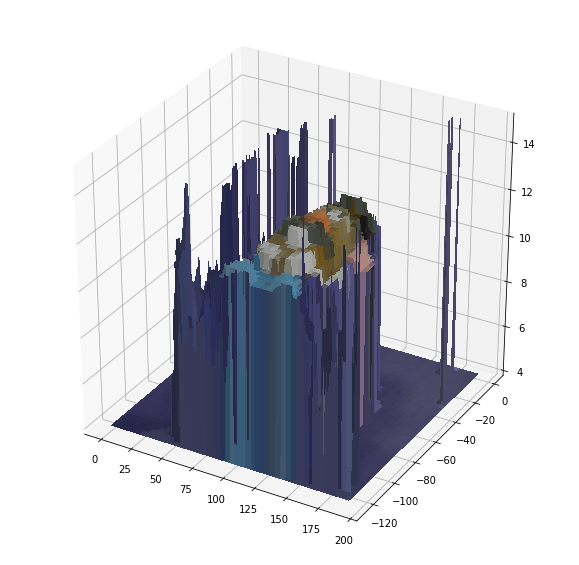

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection = '3d')

# This works if you computed the disparity map with respect
# to the left image (img1).
rgba = np.ones((img1.shape[0], img1.shape[1], 4))
rgba[:, :, :3] = img1
surf = ax.plot_surface(X, -Y, Z, facecolors = rgba, linewidth=0, antialiased=False)
# ax.set_zlim(0, 12)
plt.show()

**Final comments:** In this lab we reconstructed depth information from the disparity map between two images taken of the same object from two slightly different viewpoints. You experienced two ways to compute the disparity map. You also had to deal with removing artifacts after the disparity map computation.

Credits: The images were used in assignments at Stony Brook University. Prof. Dimitris Samaras, Prof. Manuel Oliveira and others seemed to have used this at some point or another but I am actually not sure of the original person capturing the image, or the time when it was captured. Toy story was released in 1995, so it has be after that. If you capture a similar image and your disparity map computation works, please share the images with the instructor.